## morpho_n_inputs_analysis
Analysis of the n inputs experiments of the morphologically detailed CA1 pyramidal cell model from `./scripts/n_inputs_morpho.py`. 

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl

import elephant.statistics as estats
import elephant
import neo
from elephant.spike_train_dissimilarity import victor_purpura_distance
from elephant.spike_train_dissimilarity import van_rossum_distance
from quantities import ms, s, Hz

In [2]:
# load data
figures_dir = '../figures/'
data_dir = '../data/nInputs_morpho/'

In [3]:
data_files = os.listdir(data_dir)

In [4]:
ns = [n for n in range(3,31)]

## look at a single experiment

In [5]:
exp_ind = 0
exp_id = (2-len(str(exp_ind)))*'0'+str(exp_ind)
obv_spikes_file = f'{data_dir}nim{exp_id}_obv_spikes.csv'
with open(obv_spikes_file, 'r') as fin:
    obv_spikes = [float(line.strip()) for line in fin.readlines()]

nim_spikes = {}
for n in ns:
    nim_spikes_file = f'{data_dir}nim{exp_id}_{n}_rep_spikes.csv'
    with open(nim_spikes_file, 'r') as fin:
        nim_spikes[n] = [float(line.strip()) for line in fin.readlines()]

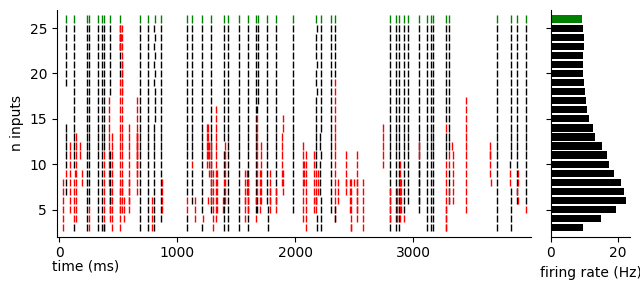

In [6]:
ns2show = [n for n in range(3,26)]

def spike_dif_thresh(spike_dif):
    if spike_dif < 1:
        return 'black'
    else:
        return 'red'

fig, axes = plt.subplots(1,2, figsize = (6.5,3), width_ratios=(6,1), sharey=True)

for n in ns2show:
    spike_difs = [min([abs(spike-obv_spike) for obv_spike in obv_spikes]) for spike in nim_spikes[n]]
    colors = [spike_dif_thresh(spike_dif) for spike_dif in spike_difs]
    axes[0].vlines(nim_spikes[n], n-0.4, n+0.4, color=colors, linewidth=1)
    
axes[0].vlines(obv_spikes, max(ns2show)+1-0.4, max(ns2show)+1+0.4, color='green', linewidth=1)

axes[0].set_xlim(0-20, 4000)
axes[0].set_xticks(np.arange(0,3001,1000))
axes[0].set_ylim(min(ns2show)-1, max(ns2show)+1+1)
axes[0].set_yticks(
    list(np.arange(5,26,5)), 
    list(np.arange(5,26,5)))
axes[0].set_xlabel('time (ms)')
axes[0].set_ylabel('n inputs')

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].xaxis.set_label_coords(0.06, -.1)

firing_rates = [len(nim_spikes[n])/10 for n in ns2show] + [len(obv_spikes)/10]
plt.barh(ns2show + [max(ns2show)+1], firing_rates, color=['black']*len(ns2show) + ['green'])
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_xlabel('firing rate (Hz)')

plt.tight_layout()
plt.savefig(f'{figures_dir}nInputs_morpho_raster.svg', format='svg')

plt.show()

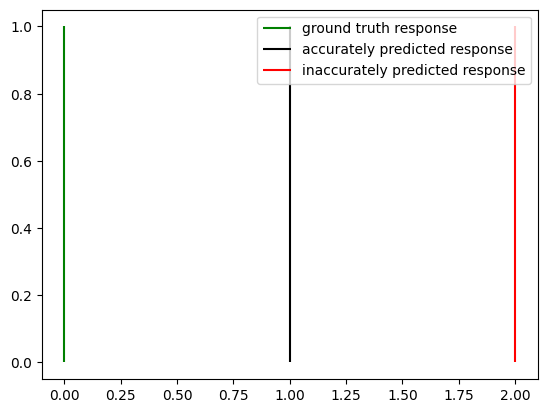

In [119]:
plt.vlines(0,0,1,color='green')
plt.vlines(1,0,1,color='black')
plt.vlines(2,0,1,color='red')
plt.legend(
    [
        'ground truth response',
        'accurately predicted response',
        'inaccurately predicted response'
    ]
)
plt.gca().xaxis.set_label_coords(-.1, .1)
plt.savefig(f'{figures_dir}nInputs_morpho_raster_legend.svg', format='svg')

## spike train distances

In [8]:
q = 1.0 / (10.0 * ms) # cost factor for shifting spikes in the victor purpura distance
tau = 10.0 * ms # time constant for the van rossum distance
sim_duration = 10000

In [51]:
spike_trains = {}
vr_dists = {}
firing_rates_ebm = []
firing_rates_ground_truth = {}

exp_inds = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,20,21,22,23,24,25,26,28,29]

for exp_ind in exp_inds:
    spike_trains[exp_ind] = {}
    vr_dists[exp_ind] = []

    exp_id = (2-len(str(exp_ind)))*'0'+str(exp_ind)
    obv_spikes_file = f'{data_dir}nim{exp_id}_obv_spikes.csv'
    with open(obv_spikes_file, 'r') as fin:
        spikes = [float(line.strip()) for line in fin.readlines()]
        spike_trains[exp_ind]['obv_train'] = neo.SpikeTrain(spikes * ms, t_stop=sim_duration*ms)
        _firing_rate_ground_truth = len(spikes) / (sim_duration / 1000)
        firing_rates_ground_truth[exp_ind] = _firing_rate_ground_truth 

    for n in ns:
        nim_spikes_file = f'{data_dir}nim{exp_id}_{n}_rep_spikes.csv'
        with open(nim_spikes_file, 'r') as fin:
            spikes = [float(line.strip()) for line in fin.readlines()]
            spikes = [spike for spike in spikes if spike < sim_duration]
            _firing_rate_ebm = len(spikes) / (sim_duration / 1000)
            spike_trains[exp_ind][n] = neo.SpikeTrain(spikes * ms, t_stop=sim_duration*ms)
        _vp_dist = victor_purpura_distance([spike_trains[exp_ind]['obv_train'], spike_trains[exp_ind][n]], q)[0, 1]
        vr_dists[exp_ind].append(_vp_dist)
        
        firing_rates_ebm.append((_firing_rate_ebm, _firing_rate_ground_truth, _vp_dist, n))

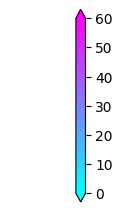

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (1,2.5))
fraction = 1  # .05

norm = mpl.colors.Normalize(vmin = 0, vmax = 60)
cbar = ax.figure.colorbar(
    mpl.cm.ScalarMappable(norm = norm, cmap = 'cool'),
    ax = ax, 
    extend = 'both',
)

#cbar.ax.tick_params(labelsize=16)

ax.axis('off')
plt.savefig(f'{figures_dir}nInputs_morpho_vr_dists_scalebar.svg', format='svg')
plt.show()

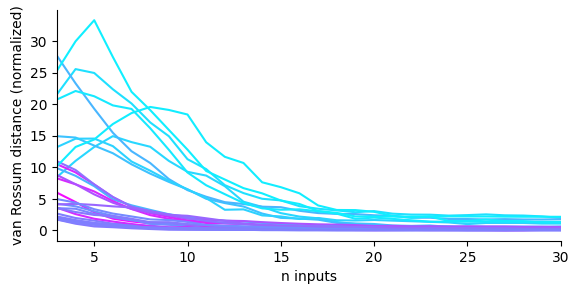

In [11]:
plt.figure(figsize=(6.5,3))

colors = pl.cm.cool(np.linspace(0,1,60))

for exp_ind in exp_inds:
    plt.plot(
        ns, np.array(vr_dists[exp_ind])/firing_rates[exp_ind], 
        color=[np.interp(firing_rates_ground_truth[exp_ind], np.linspace(0, 60, 60), colors[:,i]) for i in range(3)])

plt.ylabel('van Rossum distance (normalized)')
plt.xlabel('n inputs')
plt.xlim(3, 30)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.savefig(f'{figures_dir}nInputs_morpho_vr_dists.svg', format='svg')
plt.show()

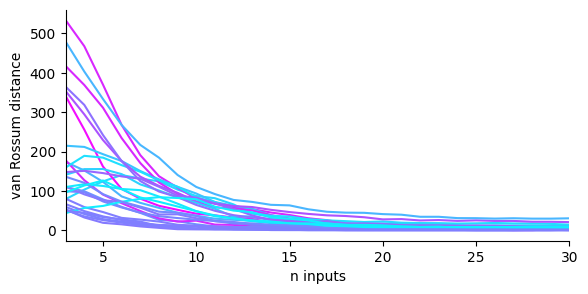

In [47]:
plt.figure(figsize=(6.5,3))

colors = pl.cm.cool(np.linspace(0,1,60))

for exp_ind in exp_inds:
    plt.plot(
        ns, 
        np.array(vr_dists[exp_ind]), 
        color=[np.interp(firing_rates_ground_truth[exp_ind], np.linspace(0, 60, 60), colors[:,i]) for i in range(3)]
    )

plt.ylabel('van Rossum distance')
plt.xlabel('n inputs')
plt.xlim(3, 30)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig(f'{figures_dir}nInputs_morpho_vr_dists.svg', format='svg')
plt.show()

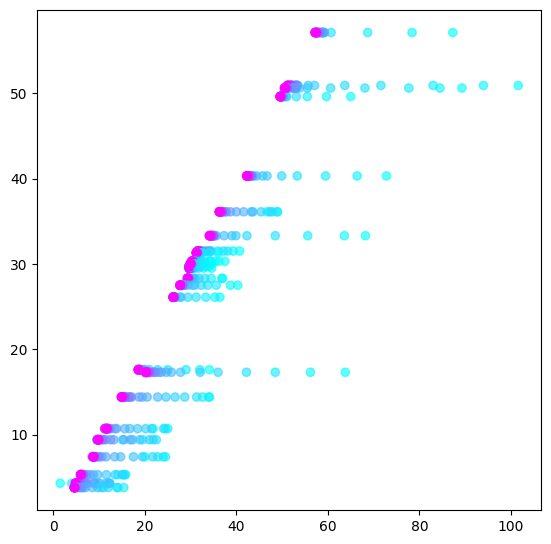

In [110]:
x = [_x[0] for _x in firing_rates_ebm]
y = [_y[1] for _y in firing_rates_ebm]
c = [_c[2] for _c in firing_rates_ebm]
n = [_n[3] for _n in firing_rates_ebm]

plt.figure(figsize=(6.5,6.5))
colors = pl.cm.cool(np.linspace(0,1,len(ns)))

plt.scatter(
    x, y,
    alpha=0.6,
    c=np.array([np.interp(n, np.linspace(min(ns), max(ns), len(ns)), colors[:,i]) for i in range(3)]).T
)

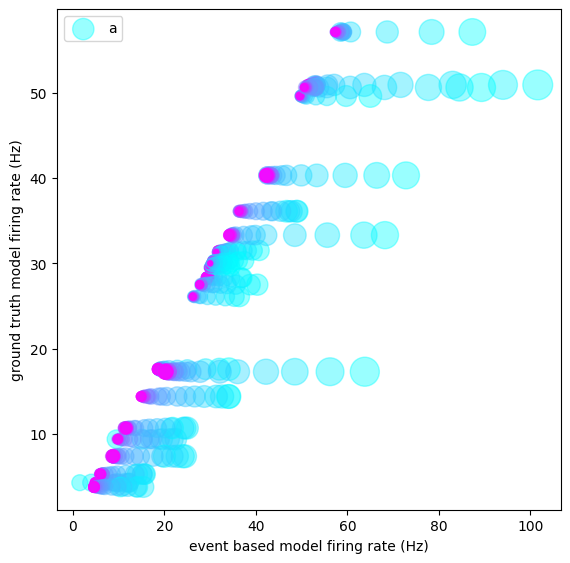

In [130]:
x = [_x[0] for _x in firing_rates_ebm]
y = [_y[1] for _y in firing_rates_ebm]
c = [_c[2] for _c in firing_rates_ebm]
n = [_n[3] for _n in firing_rates_ebm]

plt.figure(figsize=(6.5,6.5))
colors = pl.cm.cool(np.linspace(0,1,len(ns)))

plt.scatter(
    x, y,
    alpha=0.4,
    c=np.array([np.interp(n, np.linspace(min(ns), max(ns), len(ns)), colors[:,i]) for i in range(3)]).T,
    s=np.sqrt(np.array(c))*20, # make this area
)

plt.xlabel('event based model firing rate (Hz)')
plt.ylabel('ground truth model firing rate (Hz)')
plt.legend(['a'], loc='upper left')

plt.show()

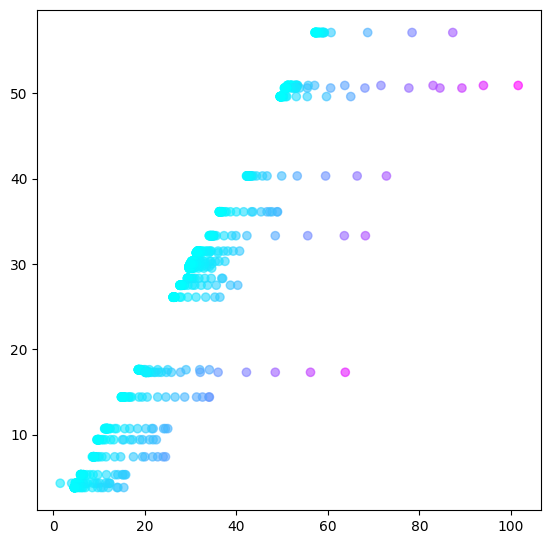

In [109]:
x = [_x[0] for _x in firing_rates_ebm]
y = [_y[1] for _y in firing_rates_ebm]
c = [_c[2] for _c in firing_rates_ebm]
n = [_n[3] for _n in firing_rates_ebm]


plt.figure(figsize=(6.5,6.5))
colors = pl.cm.cool(np.linspace(0,1,int(max(c).round() + 1)))

plt.scatter(
    x, y,
    alpha=0.6,
    c=np.array([np.interp(c, np.linspace(min(c), max(c), int(max(c).round() + 1)), colors[:,i]) for i in range(3)]).T
)

In [104]:
max(c).round() + 1

534.0